In [110]:
%load_ext autoreload
%autoreload 2

import asyncio
import os
import json
import pandas as pd
from loguru import logger
from glob import glob

from mistral_fine_tuning.levels import KnowledgeGraph, extract_graph
from mistral_fine_tuning.keywords import Topics, extract_keywords

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
folder_path = '../data/interim/jokes'
jsonl_files = glob(os.path.join(folder_path, '*.jsonl'))
all_corrected_transcripts = []

for file in jsonl_files:
    with open(file, 'r', encoding='latin-1') as f:
        for line in f:
            data = json.loads(line)
            all_corrected_transcripts.append(data['corrected_transcript'])

df = pd.DataFrame(all_corrected_transcripts, columns=['text'])
df = df.drop_duplicates()

## Word Count

In [36]:
# remove duplicates
df = df.drop_duplicates()

# add word count column
df['word_count'] = df['text'].apply(lambda x: len(x.split()))


In [37]:
df.describe()

,word_count
count,10902.000000
mean,35.557879
std,42.521441
min,1.000000
25%,11.000000
50%,25.000000
75%,50.000000
max,585.000000


<Axes: >

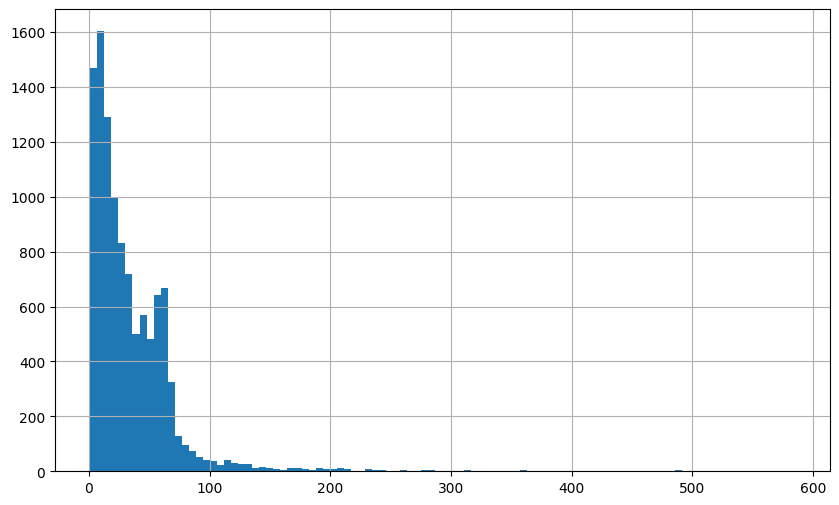

In [38]:
# histogram of word count
df['word_count'].hist(bins=100, figsize=(10, 6))

In [40]:
# remove the top 5% and then filter word_count > 10 and 
df = df[df['word_count'] < df['word_count'].quantile(0.95)]
df = df[df['word_count'] > 10]
df.shape

(7806, 2)

In [41]:
df.describe()

,word_count
count,7806.000000
mean,36.255573
std,18.960153
min,11.000000
25%,19.000000
50%,33.000000
75%,53.000000
max,85.000000


<Axes: >

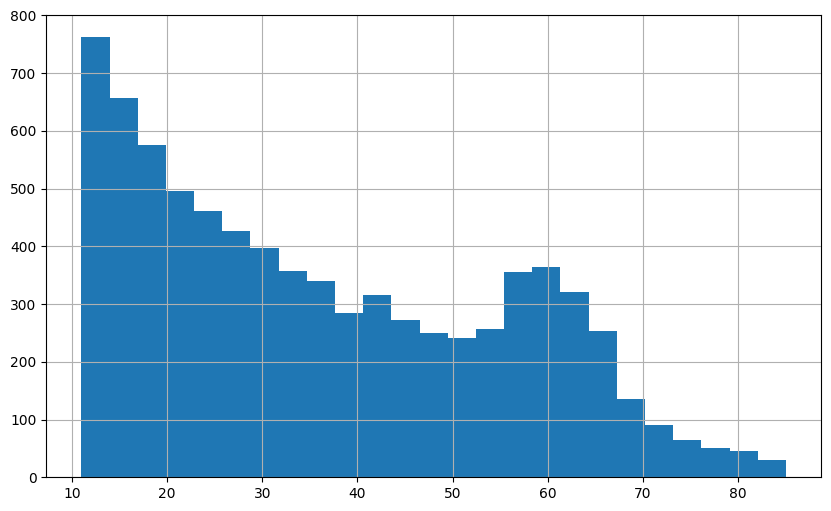

In [42]:
# histogram of word count
df['word_count'].hist(bins=25, figsize=(10, 6))

## Levels of Intentionality

In [75]:
async def levels():
    dataset = df['text'].tolist()
    sem = asyncio.Semaphore(3)

    async def rate_limited_extract_graph(text: str) -> KnowledgeGraph:
        async with sem:
            try:
                return await extract_graph(text, "es")
            except Exception as e:
                logger.error(f"Error processing text: {text}")
                logger.error(e)
                return None
    
    def safe_model_dump(graph):
        try:
            return graph.model_dump_json()
        except Exception as e:
            logger.error(f"Error converting graph: {e}")
            return None

    tasks_get_graphs = [rate_limited_extract_graph(text) for text in dataset]
    resp = await asyncio.gather(*tasks_get_graphs)
    df['graph'] = [safe_model_dump(graph) for graph in resp]

    df.to_json('../data/interim/jokes_with_graphs.jsonl', orient='records', lines=True)    

In [76]:
await levels()

2024-06-26 08:50:47.216 | ERROR    | __main__:rate_limited_extract_graph:10 - Error processing text: A veces tÃº nunca me dices nada con amor. Nunca me dices nada con amor. Nunca me dices nada con amor, amor. Fa, mira llega el cabro chico. Llega el cabro chico. Llega el cabro chico. Dice: Â¿Papi, por quÃ© te casaste con mi mamÃ¡? Por tu culpa, ese mismo gallo llega curado a la casa. Curado, curado. Antes de entrar en la casa voy a hacer una pisadita, una pisadita en el arbolito, y detrÃ¡s del Ã¡rbol aparece un gato.
2024-06-26 08:50:47.217 | ERROR    | __main__:rate_limited_extract_graph:11 - The output is incomplete due to a max_tokens length limit.
2024-06-26 09:12:27.979 | ERROR    | __main__:rate_limited_extract_graph:10 - Error processing text: EstÃ¡n pidiendo el chiste de la automotora... Va una seÃ±ora que era gordita y se acerca a un auto. Se agacha para revisar el motor y se le sale un pego. El vendedor estÃ¡ con la baterÃ­a atrÃ¡s y le pregunta: Â¿CuÃ¡nto vale este auto?
2024

122m, 56 USD

In [92]:
df = df.dropna().reset_index(drop=True)

In [93]:
def count_nodes(json_str):
    try:
        graph = json.loads(json_str)
        return len(graph.get('nodes', []))
    except json.JSONDecodeError:
        return 0

In [94]:
df['num_nodes'] = df['graph'].apply(count_nodes)

In [96]:
df.describe()

,word_count,num_nodes
count,7793.000000,7793.000000
mean,36.215321,3.761581
std,18.937494,1.265105
min,11.000000,1.000000
25%,19.000000,3.000000
50%,33.000000,4.000000
75%,53.000000,4.000000
max,85.000000,13.000000


<Axes: >

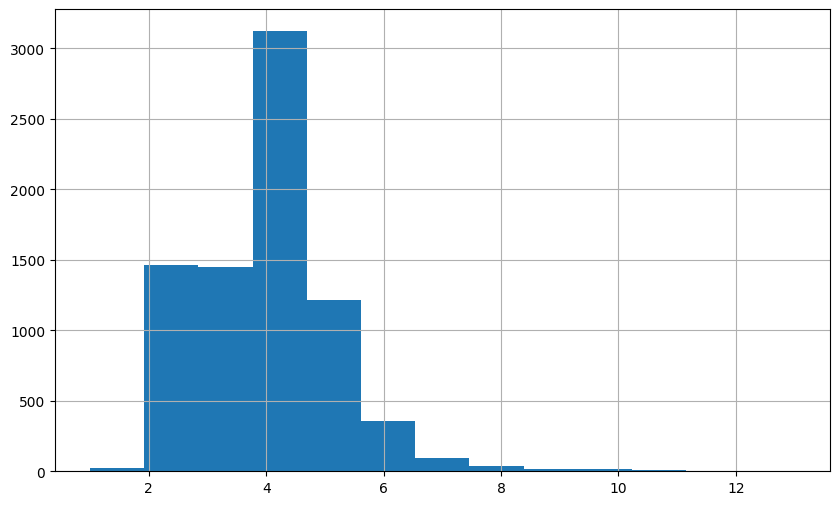

In [98]:
df['num_nodes'].hist(bins=13, figsize=(10, 6))

In [99]:
df['num_nodes'].value_counts()

num_nodes
4     3121
2     1460
3     1452
5     1217
6      354
7       93
8       37
1       21
9       16
10      13
11       6
12       2
13       1
Name: count, dtype: int64

In [100]:
# filter out jokes with less than 3 nodes and more than 6 nodes
df = df[(df['num_nodes'] >= 3) & (df['num_nodes'] <= 6)].reset_index(drop=True)
df.describe()

,word_count,num_nodes
count,6144.000000,6144.000000
mean,37.510091,4.076986
std,18.904523,0.811823
min,11.000000,3.000000
25%,21.000000,4.000000
50%,35.000000,4.000000
75%,54.000000,5.000000
max,85.000000,6.000000


## Keywords

In [116]:
async def keywords():
    dataset = df['text'].tolist()
    sem = asyncio.Semaphore(3)

    async def rate_limited_extract_keywords(text: str) -> Topics:
        async with sem:
            try:
                return await extract_keywords(text, "es")
            except Exception as e:
                logger.error(f"Error processing text: {text}")
                logger.error(e)
                return []
    
    tasks_get_graphs = [rate_limited_extract_keywords(text) for text in dataset]
    resp = await asyncio.gather(*tasks_get_graphs)

    def safe_model_dump(topics):
        try:
            return topics.model_dump_json()
        except Exception as e:
            logger.error(f"Error reading topics: {e}")
            return None

    df['keywords'] = [safe_model_dump(keywords) for keywords in resp]

    df.to_json('../data/interim/jokes_with_keywords.jsonl', orient='records', lines=True)

In [117]:
await keywords()

2024-06-26 12:38:10.101 | ERROR    | __main__:rate_limited_extract_keywords:10 - Error processing text: En el funeral del abuelo, sus dos hermanos de 92 y 95 aÃ±os llevaban el ataÃºd en un carrito y las flores en otro. El abuelito de 95 se cansÃ³ y lo sentaron en el carrito de las flores. El de 92 le dijo: "Ya estÃ¡ entrenando".
2024-06-26 12:38:10.102 | ERROR    | __main__:rate_limited_extract_keywords:11 - Status: 400. Message: {"object":"error","message":"Not the same number of function calls and responses","type":"invalid_request_error","param":null,"code":null}
2024-06-26 13:15:42.475 | ERROR    | __main__:safe_model_dump:21 - Error reading topics: 'list' object has no attribute 'model_dump_json'


In [121]:
df = df.dropna().reset_index(drop=True)

In [122]:
def count_keywords(json_str):
    try:
        topics = json.loads(json_str)
        return len(topics.get('keywords', []))
    except json.JSONDecodeError:
        return 0

In [123]:
df['num_keywords'] = df['keywords'].apply(count_keywords)

In [124]:
df.describe()

,word_count,num_nodes,num_keywords
count,6143.000000,6143.000000,6143.000000
mean,37.508546,4.076998,4.640729
std,18.905674,0.811889,1.516333
min,11.000000,3.000000,1.000000
25%,21.000000,4.000000,4.000000
50%,35.000000,4.000000,5.000000
75%,54.000000,5.000000,5.000000
max,85.000000,6.000000,19.000000


<Axes: >

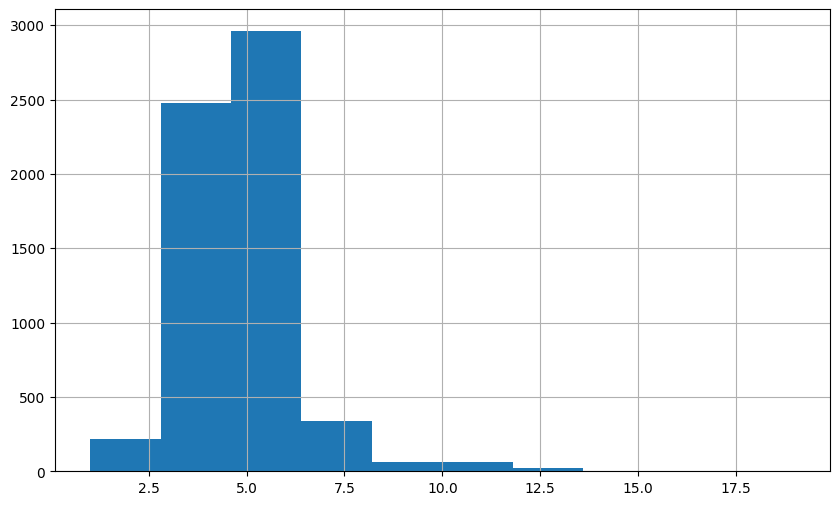

In [125]:
df['num_keywords'].hist(bins=10, figsize=(10, 6))

In [126]:
df['num_keywords'].value_counts()

num_keywords
5     2571
4     1406
3     1070
6      388
2      213
7      206
8      131
9       64
10      46
11      14
12      11
13       8
1        6
15       3
19       2
14       2
16       2
Name: count, dtype: int64

In [128]:
df.head()

,text,word_count,graph,num_nodes,keywords,num_keywords
0,"Oye, fjate que llega un indio al mdico y qu pa...",44,"{""nodes"":[{""id"":1,""label"":""Comediante""},{""id"":...",5,"{""keywords"":[""indio"",""mdico"",""Toro Sentado"",""e...",5
1,y me dio qu le pas vena una delegacin de turno...,31,"{""nodes"":[{""id"":1,""label"":""Guía Turístico""},{""...",3,"{""keywords"":[""delegacin de turnos"",""Viña del M...",4
2,Entonces el gua turstico si ustedes miran a la...,18,"{""nodes"":[{""id"":1,""label"":""Comediante""},{""id"":...",4,"{""keywords"":[""gua turstico"",""izquierda"",""derec...",4
3,y llega el tema del medio que le dice doctor m...,46,"{""nodes"":[{""id"":1,""label"":""Comediante""},{""id"":...",5,"{""keywords"":[""luna de viernes"",""seora"",""tres p...",5
4,conversando amigo y uno le dice la poblacin un...,29,"{""nodes"":[{""id"":1,""label"":""Comediante""},{""id"":...",4,"{""keywords"":[""Viagra"",""robo"",""medicamento"",""po...",5


In [133]:
def convert_keywords(keywords_str):
    # Load the string into a dictionary
    keywords_dict = json.loads(keywords_str)
    keywords_list = keywords_dict['keywords']
    return str(keywords_list).replace('"', "'")

# Apply the conversion to the 'keywords' column
df['keywords'] = df['keywords'].apply(convert_keywords)

In [136]:
df.head()

,text,word_count,graph,num_nodes,keywords,num_keywords
0,"Oye, fjate que llega un indio al mdico y qu pa...",44,"{""nodes"":[{""id"":1,""label"":""Comediante""},{""id"":...",5,"['indio', 'mdico', 'Toro Sentado', 'enfermo', ...",5
1,y me dio qu le pas vena una delegacin de turno...,31,"{""nodes"":[{""id"":1,""label"":""Guía Turístico""},{""...",3,"['delegacin de turnos', 'Viña del Mar', 'bus d...",4
2,Entonces el gua turstico si ustedes miran a la...,18,"{""nodes"":[{""id"":1,""label"":""Comediante""},{""id"":...",4,"['gua turstico', 'izquierda', 'derecha', 'quin...",4
3,y llega el tema del medio que le dice doctor m...,46,"{""nodes"":[{""id"":1,""label"":""Comediante""},{""id"":...",5,"['luna de viernes', 'seora', 'tres pechos', 'd...",5
4,conversando amigo y uno le dice la poblacin un...,29,"{""nodes"":[{""id"":1,""label"":""Comediante""},{""id"":...",4,"['Viagra', 'robo', 'medicamento', 'polica', 'h...",5


In [138]:
df.to_json('../data/interim/jokes.jsonl', orient='records', lines=True)    

In [139]:
df[['text', 'keywords']].to_json('../data/interim/jokes_fine_tuning.jsonl', orient='records', lines=True)  

## Creating the datasets for fine-tuning

In [140]:
df_quality = df[(df['word_count'] > 30)&(df['num_nodes'] > 3)].reset_index(drop=True)
df_quality.describe()

,word_count,num_nodes,num_keywords
count,2881.000000,2881.000000,2881.000000
mean,51.555016,4.513711,5.244012
std,12.923997,0.669190,1.518572
min,31.000000,4.000000,2.000000
25%,40.000000,4.000000,5.000000
50%,52.000000,4.000000,5.000000
75%,61.000000,5.000000,5.000000
max,85.000000,6.000000,19.000000


In [141]:
df_quality[['text', 'keywords']].to_json('../data/interim/quality_jokes_fine_tuning.jsonl', orient='records', lines=True)  